In [93]:
import glob

import cartopy.crs as ccrs
import cftime
import cmocean as cmo
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import om4labs.om4common as om4
import pandas as pd
import scipy.signal as signal
import xarray as xr
from scipy.stats import linregress

# parameters for setting circular cutoff for Southern Ocean plots
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

out_path_fig = "/work/Katherine.Turner/smaller_projects/hifreq-variability/figures/"
out_path_data = "/work/Katherine.Turner/smaller_projects/hifreq-variability/data/"

In [94]:
# getting SAM indices
SAM = {}
season = ["DJF", "JJA"]
for s in season:
    ds = xr.open_dataset(
        f"/work/Katherine.Turner/smaller_projects/hifreq-variability/data/ESM4_cmip_{s}_SAM.nc"
    )

    if s == "DJF":
        SAM[s] = ds.pcs[1:-1, 0]
    else:
        SAM[s] = ds.pcs[:, 0]

In [95]:
ds = xr.open_dataset(
    "/work/Katherine.Turner/smaller_projects/hifreq-variability/data/ESM4_cmip_monthly_storms.nc",
    use_cftime=True,
)

storms_seasonal = ds.center_counts.resample(time="QS-DEC").sum()

idx_jja = storms_seasonal.time.dt.month == 6
idx_djf = storms_seasonal.time.dt.month == 12

storms_djf = (storms_seasonal[idx_djf][1:-1] - storms_seasonal[idx_djf][1:-1].mean())/storms_seasonal[idx_djf][1:-1].std()
storms_jja = (storms_seasonal[idx_jja] - storms_seasonal[idx_jja].mean())/storms_seasonal[idx_jja].std()

STV = {}
STV['DJF'] = storms_djf
STV['JJA'] = storms_jja

low_storms = {}
high_storms = {}

low_storms["DJF"] = storms_djf.sortby(storms_djf).time[:50]
high_storms["DJF"] = storms_djf.sortby(storms_djf).time[-50:]

low_storms["JJA"] = storms_jja.sortby(storms_jja).time[:50]
high_storms["JJA"] = storms_jja.sortby(storms_jja).time[-50:]

In [99]:
idx_nSAM = {}
idx_loSTV = {}
idx_hiSTV = {}
for s in season:
    idx_nSAM[s] = (SAM[s] >= SAM[s].quantile(0.25)) & (SAM[s] <= SAM[s].quantile(0.75))
    idx_loSTV[s] = (STV[s] <= STV[s].quantile(0.2)) &  idx_nSAM[s]
    idx_hiSTV[s] = (STV[s] >= STV[s].quantile(0.8)) &  idx_nSAM[s]

In [103]:
s='DJF'
s, idx_hiSTV[s].sum(), idx_loSTV[s].sum()

('DJF',
 <xarray.DataArray ()>
 array(44)
 Coordinates:
     quantile  float64 0.8
     mode      int64 0,
 <xarray.DataArray ()>
 array(49)
 Coordinates:
     quantile  float64 0.2
     mode      int64 0)

# Loading in variable of choice and creating SAM residuals for compositing

In [1]:
def regress(y, x):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope, intercept  # or return r_value, p_value, etc.

def get_SAM_residuals(SAM_index, da):
    # Apply regression across lat/lon grid
    slope_map = xr.apply_ufunc(
        regress,
        da,
        SAM_index,
        input_core_dims=[["time"], ["time"]],
        vectorize=True,
        dask="parallelized",  # optional: speeds things up with dask
        output_dtypes=[float],
    )

    resid = da - da.mean(dim="time") - SAM_index * slope_map
    return resid, slope_map, intercept_map

In [122]:
realm = "ocean_monthly"
var = "tos"

if var == "hf_turb":
    ds_v = xr.open_mfdataset(
        f"/work/Katherine.Turner/tempest-extremes/ESM4_cmip/data/ocean_monthly_1x1deg*hf*.nc",
        use_cftime=True,
    )
    ds_v = ds_v.assign(hf_turb=ds_v["hflso"] + ds_v["hfsso"])
    
else:
    ds_v = xr.open_mfdataset(
        f"/work/Katherine.Turner/tempest-extremes/ESM4_cmip/data/{realm}*{var}.nc",
        use_cftime=True,
    )

da_v = ds_v[var]

da_v_s = da_v.resample(time="QS-DEC").sum()

da = {}

da["DJF"] = (da_v_s[4:-4:4, :, :] / 3).compute()
da["JJA"] = (da_v_s[2::4, :, :] / 3).compute()

In [123]:
da_resid = {}
slope = {}

idx_high = {}
idx_low = {}

for s in season:
    da_resid[s], slope[s] = get_SAM_residuals(SAM[s], da[s])

    idx_high[s] = da_resid[s].time.dt.year.isin(high_storms[s].dt.year)
    idx_low[s] = da_resid[s].time.dt.year.isin(low_storms[s].dt.year)

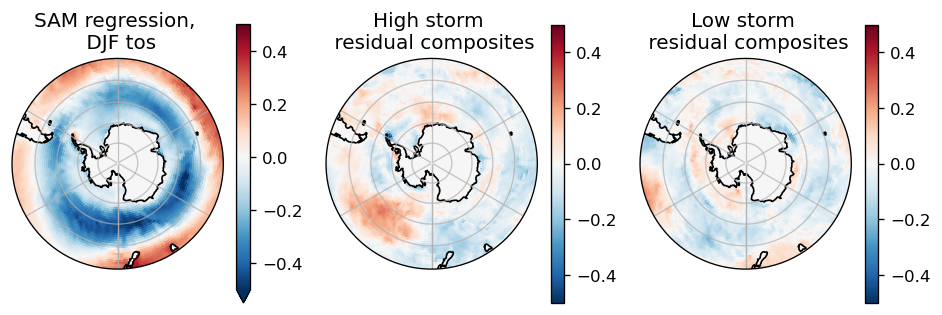

In [126]:
s = "DJF"
fig, axs = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(8, 2.7),
    dpi=120,
    subplot_kw={"projection": ccrs.SouthPolarStereo()},
)
axs = axs.flatten()

slope[s].plot(
    ax=axs[0],
    vmin=-0.5,
    vmax=0.5,
    cmap="RdBu_r",
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
)
axs[0].set_title(f"SAM regression, \n {s} {var}")

da_resid[s][idx_high[s], :, :].mean(dim="time").plot(
    ax=axs[1],
    vmin=-0.5,
    vmax=0.5,
    cmap="RdBu_r",
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
)
axs[1].set_title(f"High storm \n residual composites")

da_resid[s][idx_low[s], :, :].mean(dim="time").plot(
    ax=axs[2],
    vmin=-0.5,
    vmax=0.5,
    cmap="RdBu_r",
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
)
axs[2].set_title(f"Low storm \n residual composites")

for i in range(3):
    axs[i].set_ylabel("")
    axs[i].set_xlabel("")
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()

plt.tight_layout()

# Creating multiple linear regression with SAM and STV

In [9]:
season

['DJF', 'JJA']

In [73]:
import statsmodels.api as sm

X = {}

for s in season:
    X[s] = xr.Dataset({'SAM': SAM[s]})#, 'STV': STV[s]})
    X[s] = sm.add_constant(X[s].to_array().transpose('time', ...))

In [77]:
realm = "ocean_monthly"
var = "omldamax"

if var == "hf_turb":
    ds_v = xr.open_mfdataset(
        f"/work/Katherine.Turner/tempest-extremes/ESM4_cmip/data/ocean_monthly_1x1deg*hf*.nc",
        use_cftime=True,
    )
    ds_v = ds_v.assign(hf_turb=ds_v["hflso"] + ds_v["hfsso"])
    
else:
    ds_v = xr.open_mfdataset(
        f"/work/Katherine.Turner/tempest-extremes/ESM4_cmip/data/{realm}*{var}.nc",
        use_cftime=True,
    )

da_v = ds_v[var]

da_v_s = da_v.resample(time="QS-DEC").sum()

da = {}

da["DJF"] = (da_v_s[4:-4:4, :, :] / 3).compute()
da["JJA"] = (da_v_s[2::4, :, :] / 3).compute()

In [78]:
r2 = {}
r2['DJF'] = np.zeros(shape=(60,360))
r2['JJA'] = np.zeros(shape=(60,360))

for s in season:
    for i in range(60):
        for j in range(360):
            if da[s][0,i,j] != 0:
                model = sm.OLS(da[s][:,i,j].values, X[s])
                r2[s][i,j] = model.fit().rsquared
            else:
                r2[s][i,j] = np.nan

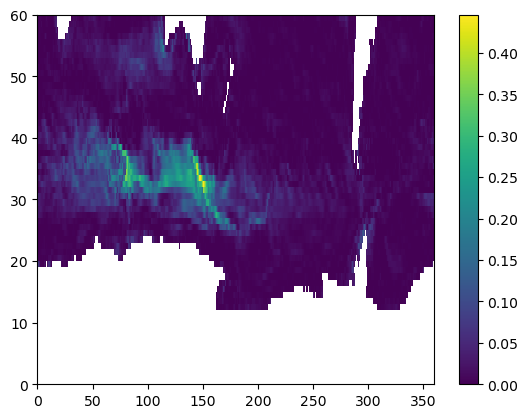

In [80]:
plt.pcolormesh(r2['JJA'])
plt.colorbar()